# Results Analysis

This notebook is intended to read a simulation results file and report the analysis.

In [38]:
%matplotlib inline

import os
import sys 
import json
import networkx as nx
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from networkx.readwrite import json_graph
from datetime import date
from collections import defaultdict, Counter
from operator import itemgetter
from itertools import groupby, chain
from copy import deepcopy 

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.utils.timez import epochptime

matplotlib.style.use('ggplot')

In [2]:
# Specify a path to a results file 
FIXTURES = os.path.join("..", "fixtures")
# RESULTS  = os.path.join(FIXTURES, 'test-raft-single.json')
# RESULTS  = os.path.join(FIXTURES, 'test-eventual-single.json')
RESULTS  = os.path.join(FIXTURES, "results", 'test-tags-single.json')

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        return json.load(f)

# Load the data
data = get_results_data()

In [3]:
def title(text):
    return " ".join([t.capitalize() for t in text.split("_")])

def report(data, title=None, total=None, sort=True):
    """
    Expects data to be a list of (name, value) pairs.
    Total will be computed from data or accepted if passed in.
    Title will be the header for the report. 
    """
    if total is None:
        total = sum(val[1] for val in data)
    
    if title is None:
        title = "Key/Val Report"
    
    if sort:
        data = sorted(data, key=itemgetter(0))
    
    # Banner length and max key length
    blen = len(title)
    klen = max([max([len(val[0]) for val in data]), len('total')])
    fmtr = "{{: <{}}} {{: >{}}}".format(klen, blen-klen-1)
    
    output = [title, "="*blen]
    
    for key, val in data:
        output.append(fmtr.format(key, val))
                
    output.append("-"*blen)
    output.append(fmtr.format('total', total))
    return "\n".join(output)

def report_details():
    banner = (
        "Simulation: {} (Cloudscope v{})\n"
        "{}\n\n"
        "Ran on: {} ({})\n\n"
        "Settings\n"
        "========\n"
    ).format(
        data['simulation'], data['version'], data['topology']['meta']['description'],
        epochptime(data['timer']['started']).strftime('%b %d, %Y at %H:%M %Z'), 
        data['timer']['elapsed'],
        data['randseed'],
    )
    
    longest = max(len(key) for key in data['settings'])
    frmt = "{{: <{0}}} {{: >12}}".format(longest)
    
    
    return banner + "\n".join([
        frmt.format(title(key), value)
        for key, value in data['settings'].items()
    ])
    

def report_topology():
    topology = deepcopy(data['topology'])
    nodes = topology['nodes']
    links = topology['links']
    
    for link in links:
        latency = [link['latency']] if link['connection'] == 'constant' else link['latency']
        
        for rid in ('source', 'target'):
            node = nodes[link[rid]]
            
            if 'minlat' not in node:
                node['minlat'] = latency[0]
            else:
                
                node['minlat'] = min(node['minlat'], latency[0])

            if 'maxlat' not in node:
                node['maxlat'] = latency[-1]
            else:
                node['maxlat'] = max(node['maxlat'], latency[-1])
         
    output = []
    for node in sorted(nodes, key=itemgetter('id')):
        output.append(
            "{}: {} ({}, {}) {}-{}ms connection".format(
                node['id'], node['label'], node['location'], node['consistency'], node['minlat'], node['maxlat']
            )
        )
    return "\n".join(output)

In [4]:
def report_reads_writes():
    counts = defaultdict(Counter)
    totals = Counter()
    for access in ('read', 'write'):
        for (rid, loc, ts) in data['results'].get(access, []):
            counts[rid][access] += 1
            totals[access] += 1
    
    total = "{}/{}".format(totals['read'], totals['write'])
    
    return report([
            (rid, "{}/{}".format(c['read'], c['write']))
            for rid, c in counts.items()
        ], "Accesses (read/write)", total=total)

In [5]:
def report_stale_reads():
    stale = data['results'].get('stale reads', [])
    if not stale:
        return "No Stale Reads"
    
    stale.sort(key=itemgetter(0))
    
    return report([
            (rid, sum(1 for v in values))
            for rid, values in groupby(stale, itemgetter(0))
        ], "Stale Reads")

In [6]:
def report_visibility_latencies():
    visibilities = data['results'].get('visibility latency', [])
    if not visibilities:
        return "No visibility latency metrics" 
    
    latencies = defaultdict(list)
    versions  = set([])
    
    for writer, vid, start, finish in visibilities:
        latencies[writer].append(finish - start)
        versions.add(vid)
    
    total  = sum(l for l in chain(*latencies.values())) / sum(1 for l in chain(*latencies.values()))
    total  = "{:0.4f} secs".format(total / 1000)

    header =  (
        "Fully visible writes:{: >6}\n"
        "Total number of writes:{: >4}\n\n"
    ).format(len(versions), len(data['results']['write']))
    
    return header + report([
        (rid, "{:0.4f} secs".format((sum(l) / len(l)) / 1000))
        for rid, l in latencies.items()
    ], 'Mean Visibility Latency', total=total)

In [7]:
def draw_topology():
    cmap = {
        'strong': '#91cf60',
        'medium': '#ffffbf',
        'low': '#fc8d59',
    }
    
    lmap = {
        'constant': 'solid',
        'variable': 'dashed',
    }

    G = json_graph.node_link_graph(data['topology'])
    colors = [cmap[n[1]['consistency']] for n in G.nodes(data=True)]
    links  = [lmap[n[2]['connection']] for n in G.edges(data=True)]
    nx.draw_circular(G, with_labels=True, node_size=800, node_color=colors, font_weight='bold', style=links, edge_color='#333333')

In [8]:
def create_dataframe():
    table = []
    meta  = data['topology']['meta']
    conf  = data['settings']

    results = data['results']
    item    = {'rid': "e{:0>2}".format(0)}
    item['variable (ms)'] = meta['variable']

    # Variable latency 
    latency = meta['variable'].rstrip('ms').strip().split('-')
    latency = sum(map(float, [ms for ms in latency if ms != 'N/A'])) / 2

    # Constant latency 
    if not latency:
        latency = float(meta['constant'].rstrip('ms').strip())

    item['mean latency (ms)'] = latency
    item['constant (ms)'] = meta['constant']
    item['users'] = conf['users']
    item['anti-entropy delay (ms)'] = conf['anti_entropy_delay']
    for key, values in results.iteritems():
        if key == 'visibility latency':
            item['visibility latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
            item['visible writes'] = len(set([v[1] for v in values]))
        if key == 'commit latency':
            item['commit latency (ms)'] = sum(v[3] - v[2] for v in values) / len(values)
            item['committed writes'] = len(set([v[1] for v in values]))
        else:
            item[key] = len(values)

    item['ratio fully visible to writes'] = float(item.get('visible writes', 0)) / float(item['write'])

    table.append(item)
    
    return pd.DataFrame(table)

df = create_dataframe()

In [9]:
def create_dataframe():
    
    # Handlers for various rows: return a dictionary to add to data frame. 
    def default_handler(key, values):
        return {
            key: len(values) 
        }
    
    def handle_visibility_latency(key, values):
        return {
            "visibility latency (ms)": sum(v[2] - v[1] for v in values) / len(values), 
            "visible writes": len(set([v[1] for v in values]))
        }
    
    def handle_commit_latency(key, values):
        return {
            "commit latency (ms)": sum(v[2] - v[1] for v in values) / len(values),
            "committed writes": len(set([v[1] for v in values]))
        }

    def handle_session_length(key, values):
        return {
            "sessions": len(values), 
            "mean session duration (ms)": sum(v[0] for v in values) / len(values),
        }

    def handle_read_latency(key, values):
        return {
            "completed reads": len(values), 
            "mean read latency (ms)": sum(v[0] for v in values) / len(values),
        }
    
    def handle_tag_size(key, values):
        return {
            "average tag size": sum(v[1] for v in values) / len(values)
        }
    
    def rename_key(name, func=default_handler):
        def handle_rename(key, values):
            item = func(key, values)
            return {
                name: item[key]
            }
        return handle_rename
        

    # Handler map 
    handlers = {
        'visibility latency': handle_visibility_latency, 
        'commit latency': handle_commit_latency, 
        'session length': handle_session_length,
        'read latency': handle_read_latency,
        'tag size': handle_tag_size,
        'read': rename_key('reads'),
        'write': rename_key('writes'),
    }
    
    replicas = defaultdict(lambda: defaultdict(list)) 
    topology = data['topology']
    config   = data['settings']
    results  = data['results']
    
    # Extract per-replica ID values from all results series 
    for key, values in results.iteritems():
        for value in values:
            # Some quick checks 
            assert len(value) > 1 
            assert value[0].startswith('r')
            
            # Append the series to the specific replica 
            replicas[value[0]][key].append(value[1:])
    
    # Create a table with each replica id
    table = []
    for replica, results in replicas.iteritems():
        row = {'replica': replica} 
        
        # Perform per-replica aggreations for each result set 
        for result, values in results.iteritems():
            handler = handlers.get(result, default_handler)
            row.update(handler(result, values))
        
        # Add in topology information 
        
        
        table.append(row)
    
    # Create the data frame and compute aggregate dependency items 
    df = pd.DataFrame(sorted(table, key=itemgetter('replica')))
    df['missed reads'] = df['reads'] - df['completed reads']
    df['dropped writes'] = df['writes'] - df ['visible writes']
    df['visibility ratio'] = df['visible writes'] / df['writes']
    
    return df

df = create_dataframe()
df 

,average tag size,completed reads,mean read latency (ms),mean session duration (ms),reads,replica,sent,sessions,visibility latency (ms),visible writes,writes,missed reads,dropped writes,visibility ratio
0,0,1,0,1050,2,r0,161,1,15,5,5,1,0,1
1,NaN,NaN,NaN,NaN,1,r1,25,NaN,NaN,NaN,7,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,r2,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,r3,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,r4,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,r5,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,r6,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,r7,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,r8,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,r9,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Results 

In [10]:
print report_details()

Simulation: Single medium Cluster (Cloudscope v0.3)
Toplogy for single medium cluster experiments.

Ran on: Mar 11, 2016 at 04:47 UTC (3 minutes 46 seconds)

Settings
Access Stddev                 512
Do Rumoring                     1
Switch Prob                   0.3
Move Prob                     0.2
Default Latency               800
Do Gossip                       1
Max Sim Time              4320000
Random Seed                    42
Access Mean                  1800
Election Timeout       [150, 300]
Heartbeat Interval             75
Default Consistency        strong
Invalid Types         [u'backup']
Read Prob                    0.68
Users                           1
Max Objects Accessed           10
Anti Entropy Delay            600
Object Prob                   0.3
Valid Locations      [u'home', u'work', u'mobile', u'cloud']
Session Timeout               300
Default Replica           storage
Count Messages                  1


## Topology

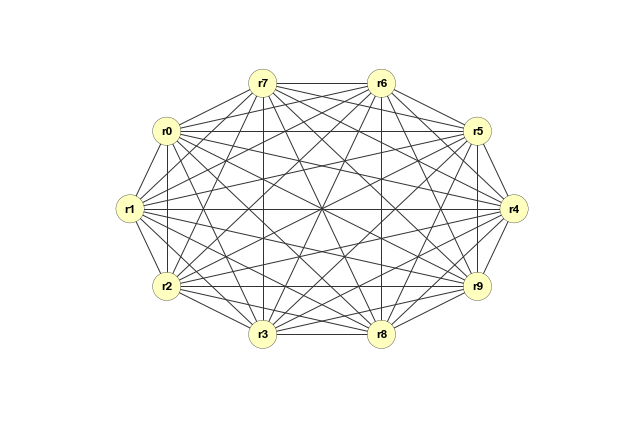

In [11]:
draw_topology()

In [12]:
print report_topology()

r0: Raft 1 (cloud, medium) 15-15ms connection
r1: Raft 2 (cloud, medium) 15-15ms connection
r2: Raft 3 (cloud, medium) 15-15ms connection
r3: Raft 4 (cloud, medium) 15-15ms connection
r4: Raft 5 (cloud, medium) 15-15ms connection
r5: Raft 6 (cloud, medium) 15-15ms connection
r6: Raft 7 (cloud, medium) 15-15ms connection
r7: Raft 8 (cloud, medium) 15-15ms connection
r8: Raft 9 (cloud, medium) 15-15ms connection
r9: Raft 10 (cloud, medium) 15-15ms connection


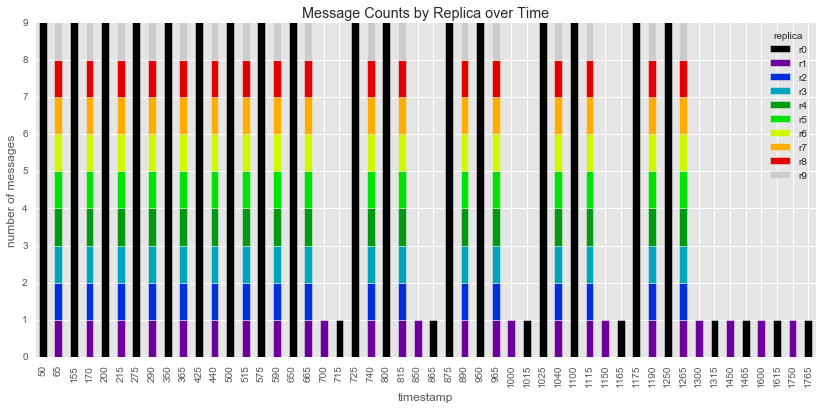

In [43]:
tsize = pd.DataFrame(data['results']['sent'])
tsize.columns = ['replica', 'timestamp']
messages = tsize.groupby(['timestamp', 'replica']).agg(len).unstack('replica').fillna(0)
ax = messages.plot(figsize=(14, 6), kind='bar', stacked=True, colormap='nipy_spectral')
ax.set_ylabel('number of messages')
ax.set_title('Message Counts by Replica over Time')

## Metrics 

The following metrics are reported from the results.

### Reads and Writes

In [14]:
print report_reads_writes()

Accesses (read/write)
r0                2/5
r1                1/7
---------------------
total            3/12


### Stale Reads

In [15]:
print report_stale_reads()

No Stale Reads


### Visibility Latency 

In [16]:
print report_visibility_latencies()

Fully visible writes:     5
Total number of writes:  12

Mean Visibility Latency
r0          0.0000 secs
-----------------------
total       0.0000 secs
